In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Load CSV
data = pd.read_csv(r'J:\CancerInst\ImmunoTherapy\Lab_Current\Guillaume Mestrallet\Experiments\brcatcga03012024\MLcorrelations7.csv')

# Assuming columns "time" (event/censoring time) and "event" (1 if event occurred, 0 if censored) are present
X = data.drop(columns=["OS_MONTHS", "OS_STATUS"])  # features
y = Surv.from_dataframe("OS_STATUS", "OS_MONTHS", data)  # Surv object

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create Leave-One-Out cross-validation procedure
#cv = LeaveOneOut()

# RandomForestSurvival model
rf_survival = RandomSurvivalForest(random_state=42)

# Hyperparameter optimization using GridSearchCV
param_grid = {
    "n_estimators": [10, 100, 200, 25, 500, 1000, 1500, 2000],
    "max_depth": [None, 10, 15, 25, 50],
    "min_samples_split": [2, 5, 7, 10, 12, 15],
    "min_samples_leaf": [1, 2, 5, 7, 10, 12, 15],
}

grid_search = GridSearchCV(rf_survival, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_
best_model

# Model Evaluation
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Concordance Index (C-index)
c_index_train = concordance_index_censored(y_train['OS_STATUS'], y_train['OS_MONTHS'], y_pred_train)
c_index_test = concordance_index_censored(y_test['OS_STATUS'], y_test['OS_MONTHS'], y_pred_test)

print(f"Training C-Index: {c_index_train[0]:.4f}")
print(f"Testing C-Index: {c_index_test[0]:.4f}")

# Combine predictions and ground truth from train and test sets
X_combined = pd.concat([X_train, X_test])
y_combined = np.concatenate([y_train, y_test])
y_pred_combined = np.concatenate([y_pred_train, y_pred_test])

# Calculate the global C-index
c_index_global = concordance_index_censored(y_combined['OS_STATUS'], y_combined['OS_MONTHS'], y_pred_combined)

print(f"Global C-Index: {c_index_global[0]:.4f}")

Training C-Index: 0.9216
Testing C-Index: 0.7649
Global C-Index: 0.8964


In [3]:
best_model

RandomSurvivalForest(max_depth=10, min_samples_leaf=10, min_samples_split=2,
                     n_estimators=200, random_state=42)

In [9]:
import shap

In [1]:
time_point = 100  # E.g., 100 days survival probability
pred_survival = np.array([fn(time_point) for fn in best_model.predict_survival_function(X_combined)])
explainer = shap.Explainer(lambda x: np.array([fn(time_point) for fn in best_model.predict_survival_function(x)]), X_combined)
shap_values = explainer(X_combined, max_evals=6500)
shap.summary_plot(shap_values, X_combined)


NameError: name 'np' is not defined

C:\ProgramData\anaconda3\Lib\site-packages\numba\core\dispatcher.py:245: UserWarning: Numba extension module 'awkward.numba' failed to load due to 'ImportError(DLL load failed while importing lib: The specified procedure could not be found.)'.
  entrypoints.init_all()
PermutationExplainer explainer: 803it [81:45:21, 366.98s/it]                            
C:\Users\mestrg01\AppData\Local\Temp\ipykernel_24924\3016823920.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values2, X_combined)


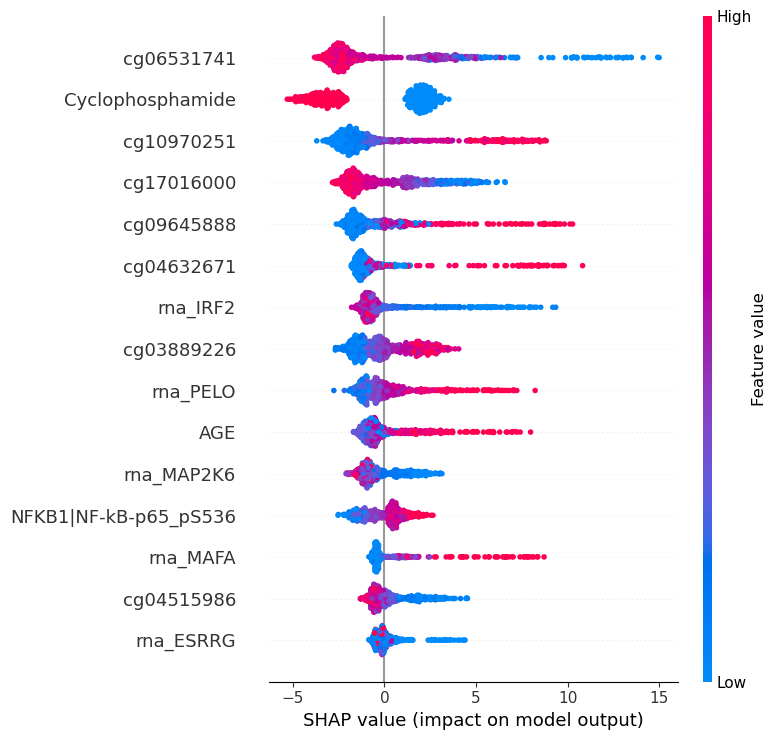

In [10]:
explainer2 = shap.Explainer(best_model.predict, X_combined)  # Approximate SHAP for predictions
shap_values2 = explainer2(X_combined, max_evals=6500)
shap.summary_plot(shap_values2, X_combined)


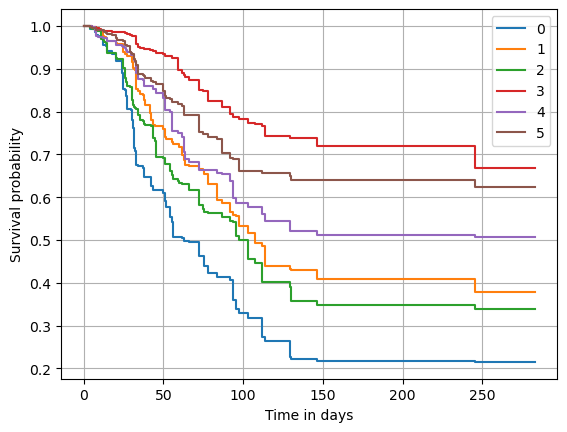

In [4]:
X_test_sorted = X_test.sort_values(by=['Cyclophosphamide','rna_ESRRG','rna_IRF2','rna_MAP2K6','cg04515986','cg06531741','cg17016000'])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

pd.Series(best_model.predict(X_test_sel))

surv = best_model.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(best_model.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

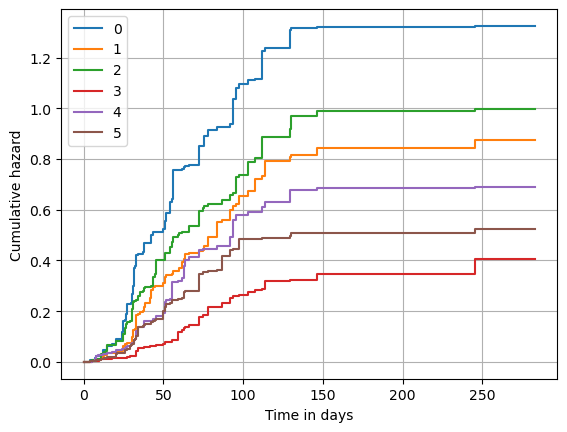

In [5]:
X_test_sorted = X_test.sort_values(by=['Cyclophosphamide','rna_ESRRG','rna_IRF2','rna_MAP2K6','cg04515986','cg06531741','cg17016000'])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

pd.Series(best_model.predict(X_test_sel))

surv = best_model.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(best_model.unique_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

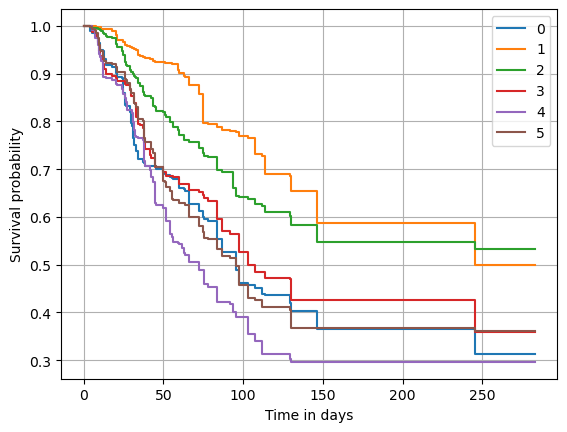

In [6]:
X_test_sorted = X_test.sort_values(by=['AGE','NFKB1|NF-kB-p65_pS536','rna_MAFA','rna_PELO','cg03889226','cg04632671','cg09645888','cg10970251'])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

pd.Series(best_model.predict(X_test_sel))

surv = best_model.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(best_model.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

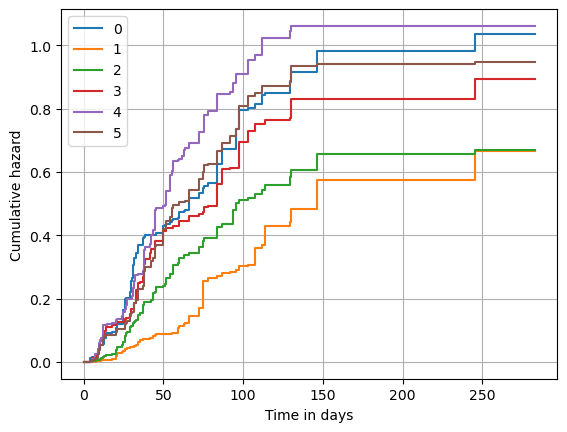

In [7]:
X_test_sorted = X_test.sort_values(by=['AGE','NFKB1|NF-kB-p65_pS536','rna_MAFA','rna_PELO','cg03889226','cg04632671','cg09645888','cg10970251'])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

pd.Series(best_model.predict(X_test_sel))

surv = best_model.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(best_model.unique_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [8]:
import pandas as pd
import numpy as np
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored

# === Load new dataset ===
new_data = pd.read_csv(r'J:\CancerInst\ImmunoTherapy\Lab_Current\Guillaume Mestrallet\Experiments\brcatcga03012024\ovarianML.csv')  # <-- Change this path

# === Prepare features (X_new) and survival labels (y_new) ===
# Ensure the column names match the original training dataset structure
X_new = new_data.drop(columns=["OS_MONTHS", "OS_STATUS"])
y_new = Surv.from_dataframe("OS_STATUS", "OS_MONTHS", new_data)

# === Predict risk scores using the trained model ===
y_pred_new = best_model.predict(X_new)

# === Evaluate using Concordance Index ===
# Convert event indicator to boolean
c_index_new = concordance_index_censored(
    y_new['OS_STATUS'].astype(bool),
    y_new['OS_MONTHS'],
    y_pred_new
)

print(f"New Dataset C-Index: {c_index_new[0]:.4f}")


New Dataset C-Index: 0.5609


In [31]:
import pandas as pd
import numpy as np
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored

# === Load new dataset ===
new_data = pd.read_csv(r'J:\CancerInst\ImmunoTherapy\Lab_Current\Guillaume Mestrallet\Experiments\brcatcga03012024\uterineML.csv')  # <-- Change this path

# === Prepare features (X_new) and survival labels (y_new) ===
# Ensure the column names match the original training dataset structure
X_new = new_data.drop(columns=["OS_MONTHS", "OS_STATUS"])
y_new = Surv.from_dataframe("OS_STATUS", "OS_MONTHS", new_data)

# === Predict risk scores using the trained model ===
y_pred_new = best_model.predict(X_new)

# === Evaluate using Concordance Index ===
# Convert event indicator to boolean
c_index_new = concordance_index_censored(
    y_new['OS_STATUS'].astype(bool),
    y_new['OS_MONTHS'],
    y_pred_new
)

print(f"New Dataset C-Index: {c_index_new[0]:.4f}")

New Dataset C-Index: 0.6179


In [10]:
import pandas as pd
import numpy as np
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored

# === Load new dataset ===
new_data = pd.read_csv(r'J:\CancerInst\ImmunoTherapy\Lab_Current\Guillaume Mestrallet\Experiments\brcatcga03012024\gliomaML.csv')  # <-- Change this path

# === Prepare features (X_new) and survival labels (y_new) ===
# Ensure the column names match the original training dataset structure
X_new = new_data.drop(columns=["OS_MONTHS", "OS_STATUS"])
y_new = Surv.from_dataframe("OS_STATUS", "OS_MONTHS", new_data)

# === Predict risk scores using the trained model ===
y_pred_new = best_model.predict(X_new)

# === Evaluate using Concordance Index ===
# Convert event indicator to boolean
c_index_new = concordance_index_censored(
    y_new['OS_STATUS'].astype(bool),
    y_new['OS_MONTHS'],
    y_pred_new
)

print(f"New Dataset C-Index: {c_index_new[0]:.4f}")

New Dataset C-Index: 0.5898


C:\ProgramData\anaconda3\Lib\site-packages\sksurv\metrics.py:483: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


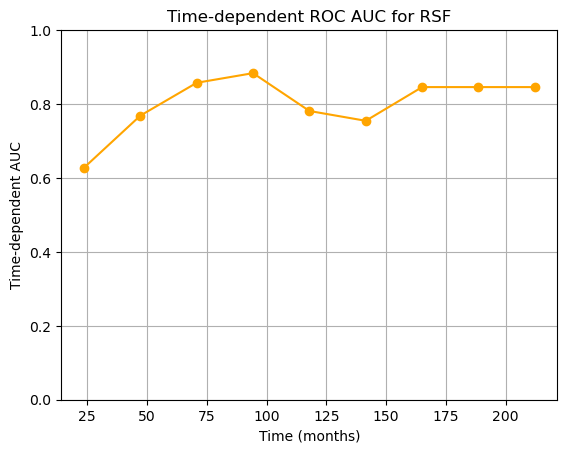

In [37]:
from sksurv.metrics import cumulative_dynamic_auc
import numpy as np

min_time = y_test["OS_MONTHS"].min()
max_time = y_test["OS_MONTHS"].max()

# Slightly shrink max time to stay strictly within interval
safe_max_time = max_time * 0.9999

# Generate safe time points
eval_times = np.linspace(min_time, safe_max_time, 10)

# Predict survival functions
pred_surv = best_model.predict_survival_function(X_test)

# Evaluate survival probabilities at the eval_times
pred_surv_matrix = np.asarray([[fn(t) for t in eval_times] for fn in pred_surv])
risk_scores = 1 - pred_surv_matrix

# Compute cumulative/dynamic AUC
cph_auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_scores, eval_times)

#plot
plt.plot(eval_times, cph_auc, marker='o', color='orange', label="UEC BRCA test")
plt.xlabel("Time (days)")
plt.ylabel("Time-dependent AUC")
plt.title("Time-dependent ROC AUC for RSF")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

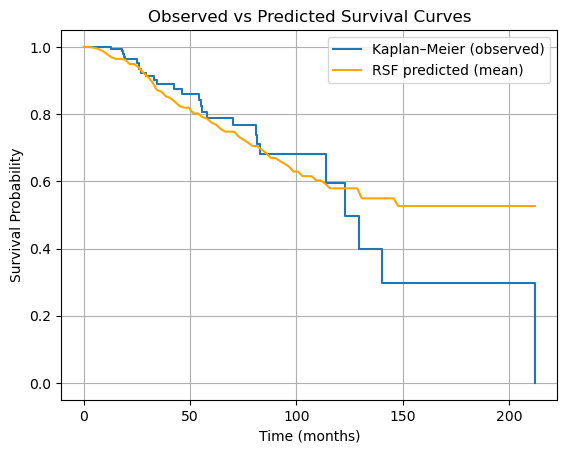

In [30]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

# Get event indicator and durations from test set
event = y_test["OS_STATUS"]
time = y_test["OS_MONTHS"]

# Compute KM estimate
km_time, km_survival = kaplan_meier_estimator(event, time)

# Predict survival functions for all test samples
pred_surv = best_model.predict_survival_function(X_test)

# Interpolate all survival functions to a common time grid
# Choose a common grid based on the KM time or a linspace
common_time_grid = np.linspace(0, time.max(), 100)

# Interpolate predicted survival values at these times
interp_surv = np.asarray([[fn(t) for t in common_time_grid] for fn in pred_surv])

# Compute mean predicted survival across all test samples
mean_pred_surv = interp_surv.mean(axis=0)

#plot
plt.step(km_time, km_survival, where="post", label="Kaplan–Meier (observed)")
plt.plot(common_time_grid, mean_pred_surv, label="RSF predicted (mean)", color="orange")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.title("Observed vs Predicted Survival Curves")
plt.grid(True)
plt.legend()
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\sksurv\metrics.py:483: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


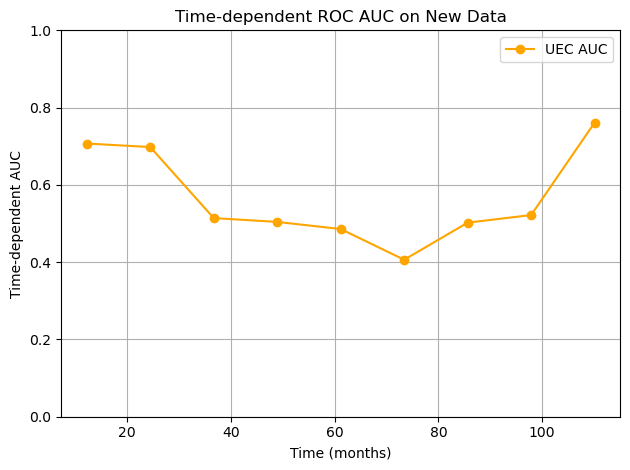

In [36]:
from sksurv.metrics import cumulative_dynamic_auc
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Determine valid evaluation time range from new data
min_time_new = y_new["OS_MONTHS"].min()
max_time_new = y_new["OS_MONTHS"].max()
safe_max_time = max_time_new * 0.9999  # to avoid upper bound violation

# Step 2: Choose time points for AUC evaluation
eval_times_new = np.linspace(min_time_new, safe_max_time, 10)

# Step 3: Predict survival for new data using trained model
pred_surv_new = best_model.predict_survival_function(X_new)
pred_surv_matrix_new = np.asarray([[fn(t) for t in eval_times_new] for fn in pred_surv_new])

# Step 4: Convert to risk scores
risk_scores_new = 1 - pred_surv_matrix_new

# Step 5: Compute cumulative dynamic AUC using training set as reference
cph_auc_new, mean_auc_new = cumulative_dynamic_auc(y_train, y_new, risk_scores_new, eval_times_new)

# Step 6: Plot
plt.plot(eval_times_new, cph_auc_new, marker='o', color='orange', label="UEC AUC")
plt.xlabel("Time (days)")
plt.ylabel("Time-dependent AUC")
plt.ylim(0, 1)
plt.title("Time-dependent ROC AUC on New Data")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

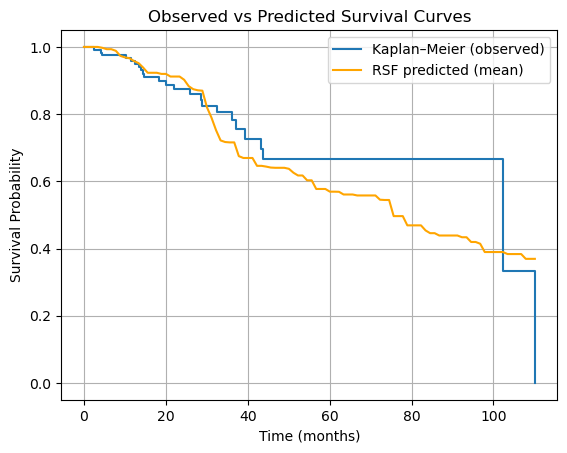

In [32]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

# Get event indicator and durations from test set
event_new = y_new["OS_STATUS"]
time_new = y_new["OS_MONTHS"]

# Compute KM estimate
km_time_new, km_survival_new = kaplan_meier_estimator(event_new, time_new)

# Predict survival functions for all test samples
pred_surv_new = best_model.predict_survival_function(X_new)

# Interpolate all survival functions to a common time grid
# Choose a common grid based on the KM time or a linspace
common_time_grid_new = np.linspace(0, time_new.max(), 100)

# Interpolate predicted survival values at these times
interp_surv_new = np.asarray([[fn(t) for t in common_time_grid_new] for fn in pred_surv_new])

# Compute mean predicted survival across all test samples
mean_pred_surv_new = interp_surv_new.mean(axis=0)

#plot
plt.step(km_time_new, km_survival_new, where="post", label="Kaplan–Meier (observed)")
plt.plot(common_time_grid_new, mean_pred_surv_new, label="RSF predicted (mean)", color="orange")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.title("Observed vs Predicted Survival Curves")
plt.grid(True)
plt.legend()
plt.show()